Today we will explore a data set dedicated to the cost of treatment of different patients. The cost of treatment depends on many factors: diagnosis, type of clinic, city of residence, age and so on. We have no data on the diagnosis of patients. But we have other information that can help us to make a conclusion about the health of patients and practice regression analysis. In any case, I wish you to be healthy! Let's look at our data.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
%matplotlib inline
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.shape

(1338, 7)

In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
print("Find most important features relative to target")
corr = data.corr()
corr.sort_values(["charges"], ascending = False, inplace = True)
corr
print(corr['charges'])

Find most important features relative to target
charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64


# Data Visualization

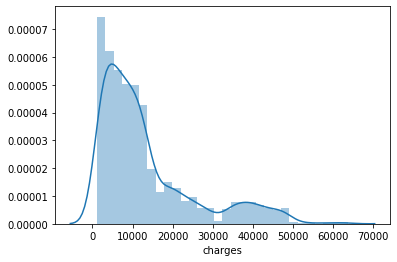

In [8]:
sns.distplot(data['charges'])

In [9]:
data['charges'].skew()

1.5158796580240388

The above distribution tells us the charge is not normally distributed, It has high skewness. We will deal with it later. Also most of charges are below 50k

# SEX

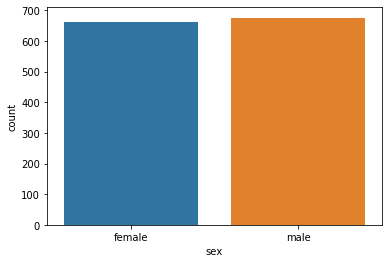

In [10]:
sns.countplot(data['sex'])

Count of male and female is more or less equal

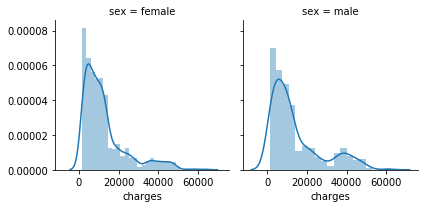

In [11]:
g=sns.FacetGrid(data,col='sex')
g=g.map(sns.distplot,"charges")


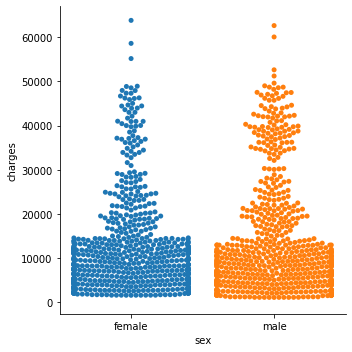

In [12]:
sns.catplot(y='charges',x='sex',data=data,kind="swarm")

It does not look there is any difference in the charging based on sex of an individual. We will explore further with other variable.
Till now insurance does not depend if you are male or female.

# SMOKER

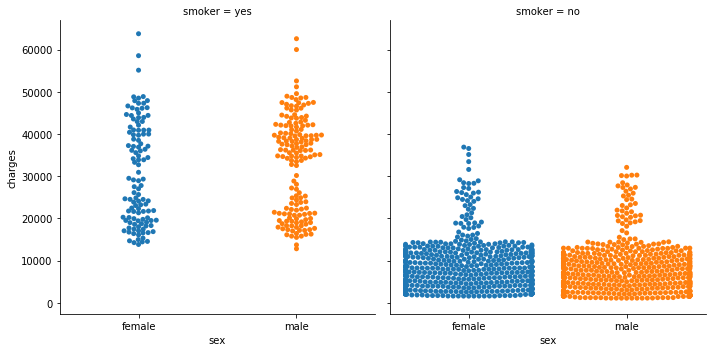

In [13]:
sns.catplot(y='charges',x='sex',col='smoker',data=data,kind="swarm")

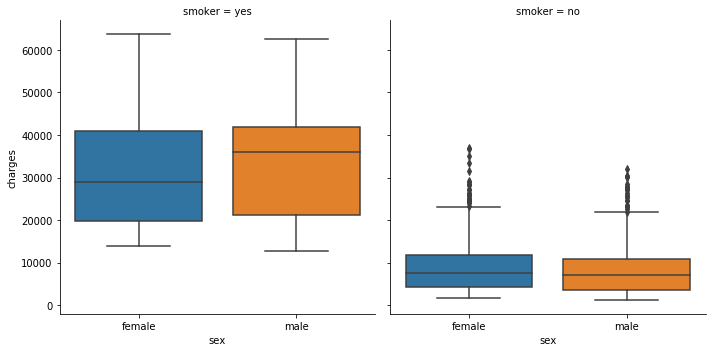

In [14]:
sns.catplot(y='charges',x='sex',col='smoker',data=data,kind="box")

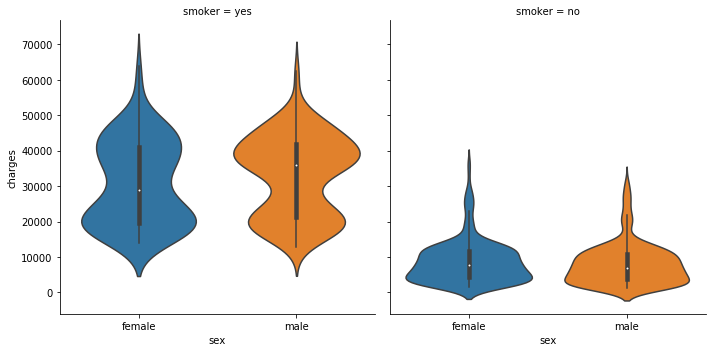

In [15]:
sns.catplot(y='charges',x='sex',col='smoker',data=data,kind="violin")

In [16]:
data[(data['smoker']=='yes')&(data['sex']=='male')]['charges'].mean()

33042.00597528302

In [17]:
data[(data['smoker']=='yes')&(data['sex']=='female')]['charges'].mean()

30678.996276260867

From the diagram it is clear that smoking has high correlation with charges, if you smoke , then insurance paid will be high irrespective
of gender. Further in the smoking categroy the mean of male smoker is higher than female smoker, need to compare with other variable like
age and bmi to know why are they charged more than female.

# Age

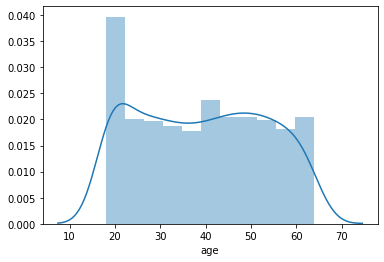

In [18]:
sns.distplot(data['age'])

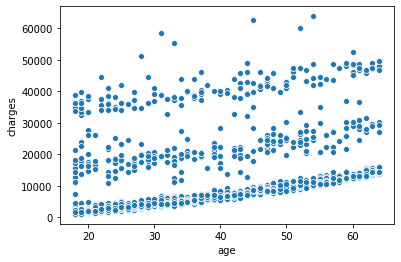

In [19]:
sns.scatterplot(x='age', y='charges',data=data)

In [20]:
data['age'].describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

From the data it is visible that the minimum age is 18 and the maximum age is 64. So if we convert this numerical data into categorical
data we can get better insight of the data.

SO lets convert the age into: 18yrs-26 yrs as young , 27yrs-40yrs as adult,41yrs to 55yrs as senior adult and 56yrs to 64yrs as Elder

In [21]:
data['age_cat']=np.NAN
lst = [data]

for col in lst:
    col.loc[(col['age'] >= 18) & (col['age'] <= 26), 'age_cat'] = 'Young'
    col.loc[(col['age'] > 26) & (col['age'] <= 40), 'age_cat'] = 'Adult'
    col.loc[(col['age'] > 40) & (col['age'] <= 55), 'age_cat'] = 'Senior Adult'
    col.loc[col['age'] > 55, 'age_cat'] = 'Elder'

In [22]:
data['age_cat'].value_counts()

Senior Adult    421
Adult           367
Young           334
Elder           216
Name: age_cat, dtype: int64

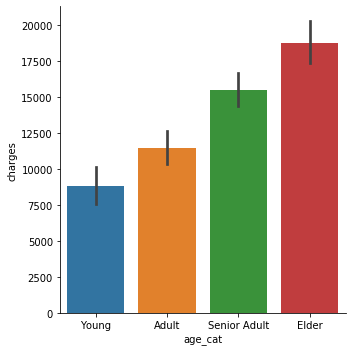

In [23]:
sns.catplot(x='age_cat', y='charges',data=data,kind='bar')

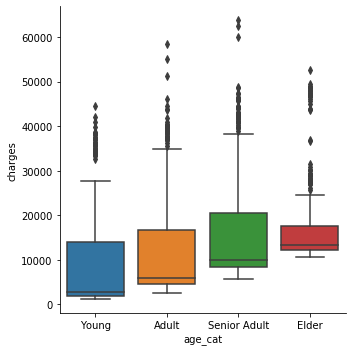

In [24]:
sns.catplot(x='age_cat', y='charges',data=data,kind='box')

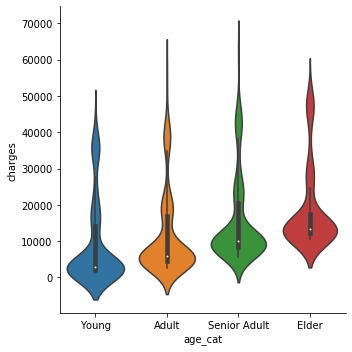

In [25]:
sns.catplot(x='age_cat', y='charges',data=data,kind='violin')

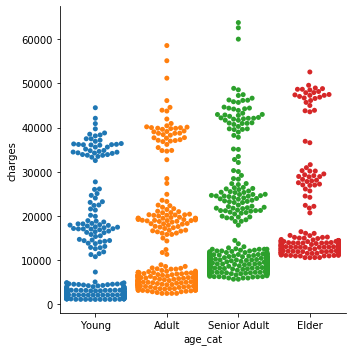

In [26]:
sns.catplot(x='age_cat', y='charges',data=data,kind='swarm')

From the above we can now easily see the corelation(ordinal) between age and charges, as the age increase insurance charge increase. But each
group has some high values need to understand the reason, using other features.

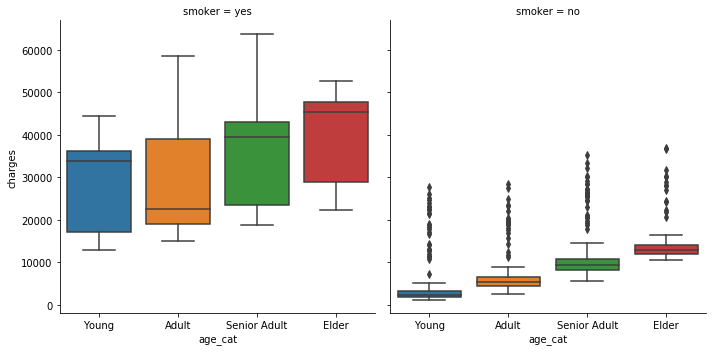

In [27]:
sns.catplot(x='age_cat', y='charges',data=data,kind='box',col='smoker')

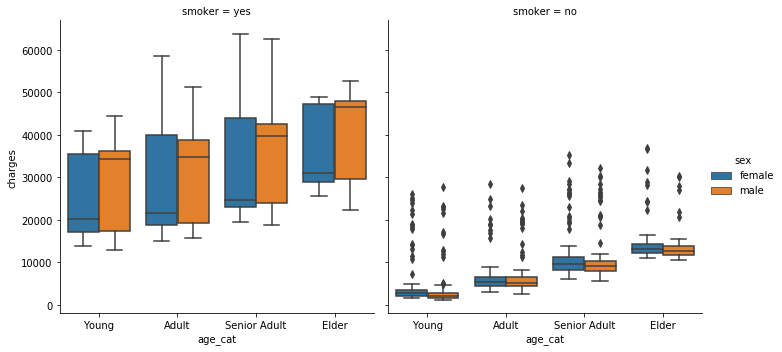

In [28]:
sns.catplot(x='age_cat', y='charges',data=data,kind='box',col='smoker',hue='sex')

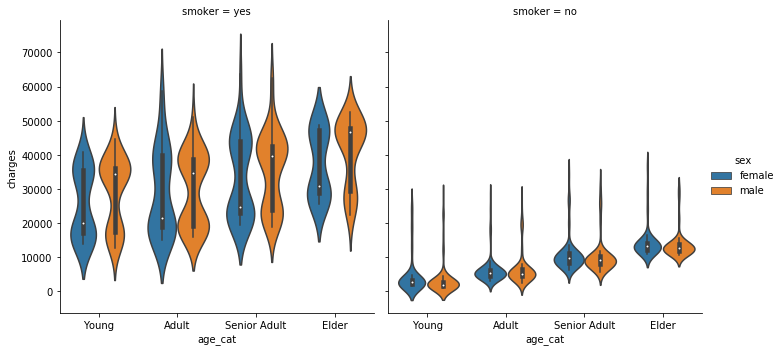

In [29]:
sns.catplot(x='age_cat', y='charges',data=data,kind='violin',col='smoker',hue='sex')

In [30]:
data[(data['age_cat']=='Adult')&(data['smoker']=='yes')&(data['sex']=='male')]['charges'].describe()

count       48.000000
mean     29621.263878
std      10518.151459
min      15820.699000
25%      19312.762675
50%      34739.307450
75%      38821.587575
max      51194.559140
Name: charges, dtype: float64

In [31]:
data[(data['age_cat']=='Adult')&(data['smoker']=='yes')&(data['sex']=='female')]['charges'].describe()

count       33.000000
mean     28947.918231
std      12586.295075
min      15006.579450
25%      18765.875450
50%      21659.930100
75%      39836.519000
max      58571.074480
Name: charges, dtype: float64

So from this we can confirm that non smoker of any age has low insurance charges in comparison to smokers.

1)In non smoker category, Males has slightly less insurance cost in comparison to female.
2)in smoker category, mean cost of male are higher than female.


In [32]:
data.head()

,age,sex,bmi,children,smoker,region,charges,age_cat
0,19,female,27.900,0,yes,southwest,16884.92400,Young
1,18,male,33.770,1,no,southeast,1725.55230,Young
2,28,male,33.000,3,no,southeast,4449.46200,Adult
3,33,male,22.705,0,no,northwest,21984.47061,Adult
4,32,male,28.880,0,no,northwest,3866.85520,Adult


# BMI

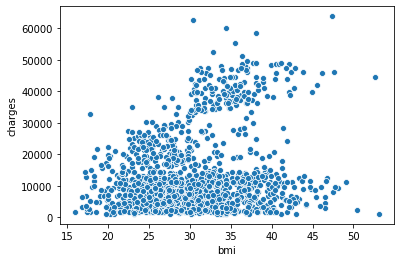

In [33]:
sns.scatterplot(x='bmi',y='charges',data=data)

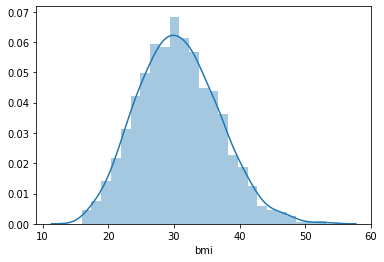

In [34]:
sns.distplot(data['bmi'])

In [35]:
data['bmi'].describe()

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64

If we see a BMI chart, there is 5 classes, 15 to 18 is underweight , 19 to 24 is healthy ,25 to 29 is overweight ,30 to 39 
is obese and greater than 40 is extremly obese.So we will divide our data into that categories.


In [36]:
data.loc[(data['bmi']>= 15)&(data['bmi']<19), 'bmi_cat'] = 'underweight'
data.loc[(data['bmi']>= 19)&(data['bmi']<25), 'bmi_cat'] = 'healthy'
data.loc[(data['bmi']>= 25)&(data['bmi']<30), 'bmi_cat'] = 'overweight'
data.loc[(data['bmi']>= 30)&(data['bmi']<40), 'bmi_cat'] = 'obese'
data.loc[(data['bmi']>= 40), 'bmi_cat'] = 'ext_obese'

In [37]:
data['bmi_cat'].value_counts()

obese          616
overweight     386
healthy        221
ext_obese       91
underweight     24
Name: bmi_cat, dtype: int64

In [38]:
data['bmi_cat'].unique()

array(['overweight', 'obese', 'healthy', 'ext_obese', 'underweight'],
      dtype=object)

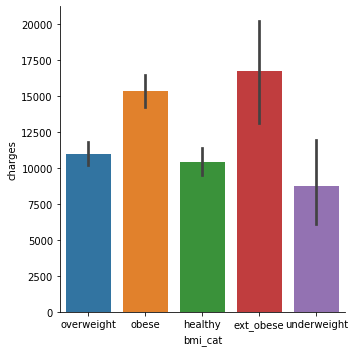

In [39]:
sns.catplot(x='bmi_cat',y='charges',kind='bar',data=data)

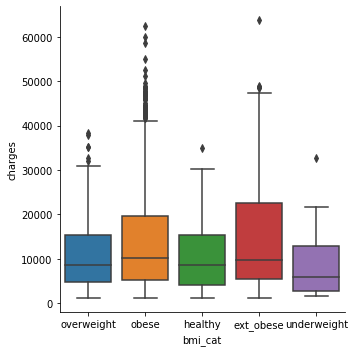

In [40]:
sns.catplot(x='bmi_cat',y='charges',kind='box',data=data)

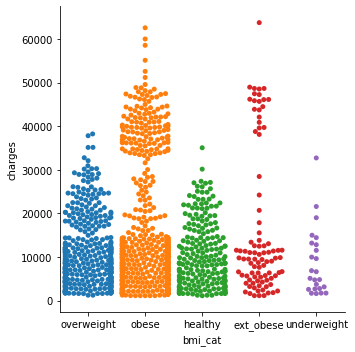

In [41]:
sns.catplot(x='bmi_cat',y='charges',kind='swarm',data=data)

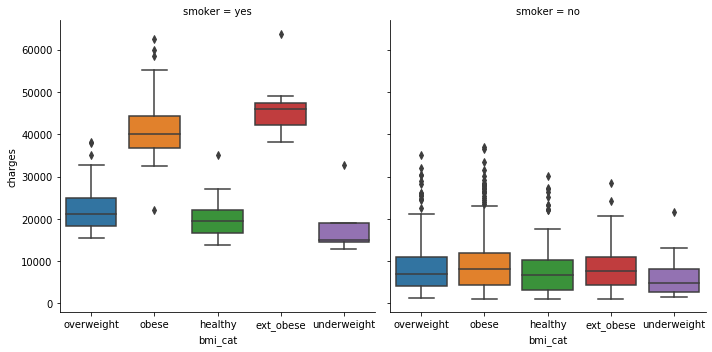

In [42]:
sns.catplot(x='bmi_cat',y='charges',col='smoker',kind='box',data=data)

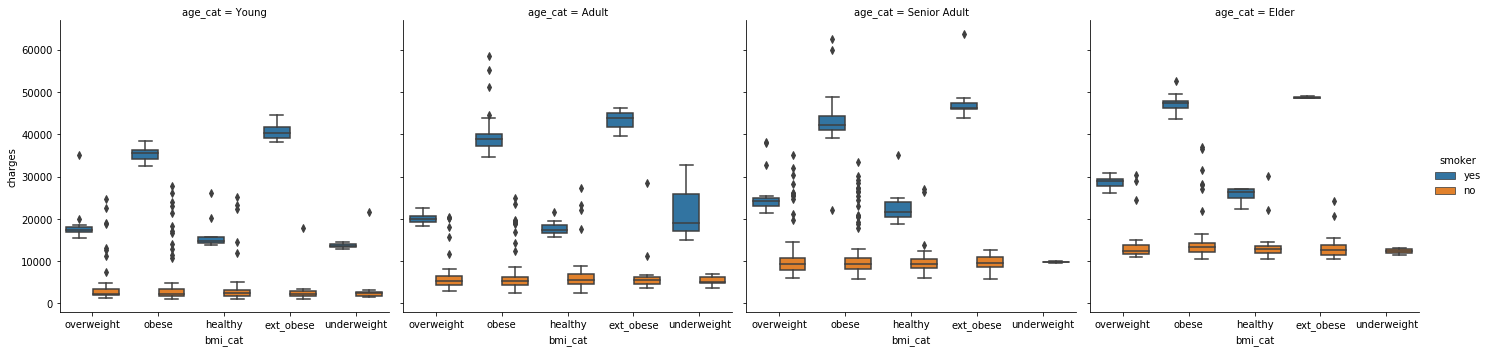

In [43]:
sns.catplot(x='bmi_cat',y='charges',col='age_cat',hue='smoker',kind='box',data=data)

Lets analyzse the above plots. In all age category on thing is common, if you are obese or more  and you smoke the expense will
be very high.
The same is applicabe for overweight and healthy but the ratio of increase is lesser than obese.
Further with increasein age, expense increases as we have seen earlier.

# CHILDREN

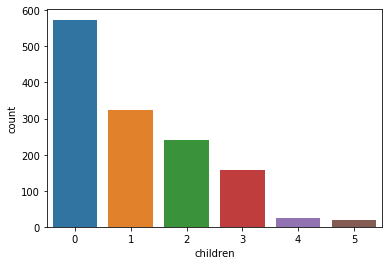

In [44]:
sns.countplot(data['children'])

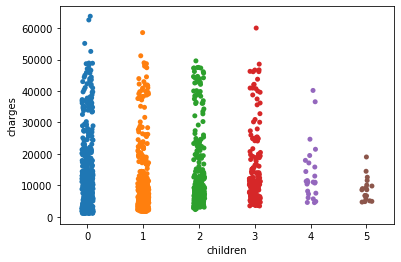

In [45]:
sns.stripplot(x="children", y="charges", data=data, size = 5, jitter = True)

In [46]:
data['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [47]:
data['children']=data['children'].map({0:'0',1:'1',2:'2',3:'3+',4:'3+',5:'3+'})

In [48]:
data['children'].value_counts()

0     574
1     324
2     240
3+    200
Name: children, dtype: int64

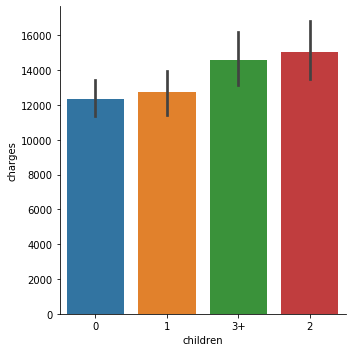

In [49]:
sns.catplot(x='children',y='charges',data=data,kind='bar')

Lets see if people tend to quit smoking or dont smoke if they have children

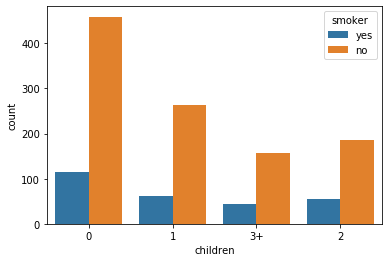

In [50]:
sns.countplot(x='children',hue='smoker',data=data)

In [51]:
data['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

No children present or not people do smoke

In [52]:
data.head()

,age,sex,bmi,children,smoker,region,charges,age_cat,bmi_cat
0,19,female,27.900,0,yes,southwest,16884.92400,Young,overweight
1,18,male,33.770,1,no,southeast,1725.55230,Young,obese
2,28,male,33.000,3+,no,southeast,4449.46200,Adult,obese
3,33,male,22.705,0,no,northwest,21984.47061,Adult,healthy
4,32,male,28.880,0,no,northwest,3866.85520,Adult,overweight


Lets see if you have more children then do you get good time to take care of yourselve, eat well, do workout etc..or you dont get time and 
time and get overweight.

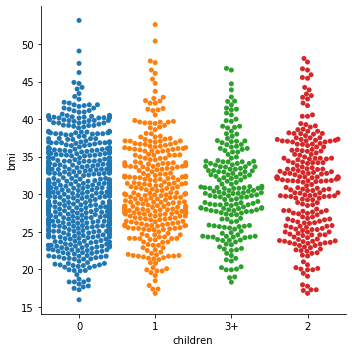

In [53]:
sns.catplot(x='children',y='bmi',data=data,kind='swarm')

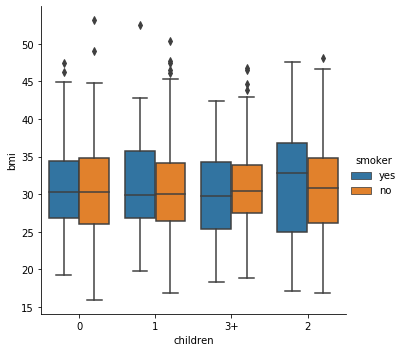

In [54]:
sns.catplot(x='children',y='bmi',hue='smoker',data=data,kind='box')

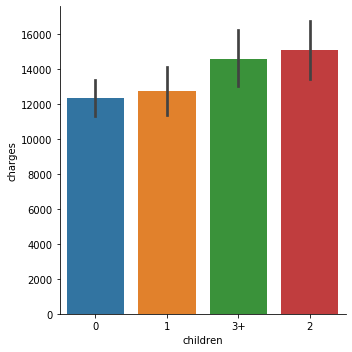

In [55]:
sns.catplot(x='children',y='charges',data=data,kind='bar')

It looks like having children dont affect your BMI. However with increase in no of children medical expense increases. but if you see above distribution we can safely say having 0 or 1 child expnse is more or less equal, similarly having 2 or more child expense will be similar. So lets disribute into two part. 'less' if no of children is less than equal to 1 and 'more; if it is greater than equal to 2.

In [56]:
data['child_cat']=np.NAN
data.loc[(data['children']=='0')|(data['children']=='1'), 'child_cat'] = 'less'
data.loc[(data['children']=='2')|(data['children']=='3+'), 'child_cat'] = 'more'

In [57]:
data.head()

,age,sex,bmi,children,smoker,region,charges,age_cat,bmi_cat,child_cat
0,19,female,27.900,0,yes,southwest,16884.92400,Young,overweight,less
1,18,male,33.770,1,no,southeast,1725.55230,Young,obese,less
2,28,male,33.000,3+,no,southeast,4449.46200,Adult,obese,more
3,33,male,22.705,0,no,northwest,21984.47061,Adult,healthy,less
4,32,male,28.880,0,no,northwest,3866.85520,Adult,overweight,less


# REGION

In [58]:
data['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

Let see the distribution of smoker based on region

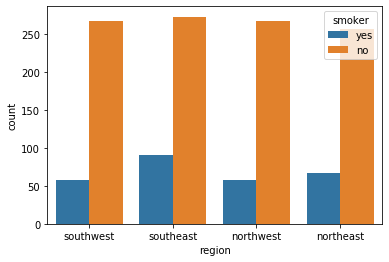

In [59]:
sns.countplot(x='region',hue='smoker',data=data)

Southeast has the maximum no of smoker followed by northeast , thus the charges will also be high for southeast followed by 
northeast.


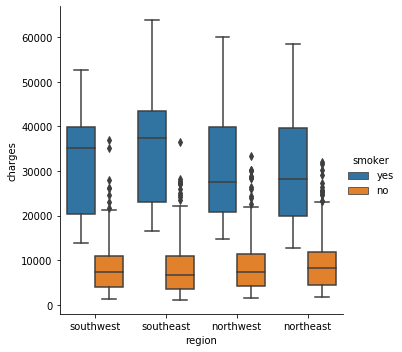

In [60]:
sns.catplot(x='region',y='charges',hue='smoker',data=data,kind='box')

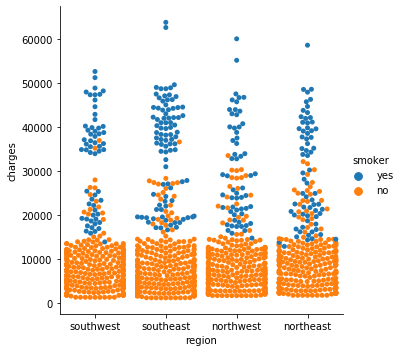

In [61]:
sns.catplot(x='region',y='charges',hue='smoker',data=data,kind='swarm')

As we thought since southeast had maximum no of smoker followed by northeast, charges are higher for southeast.

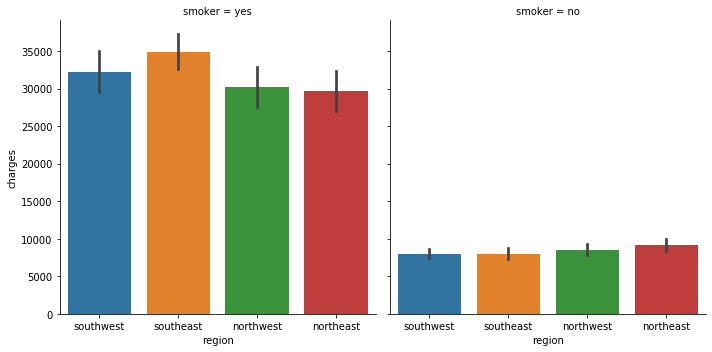

In [62]:
sns.catplot(x='region',y='charges',col='smoker',data=data,kind='bar')

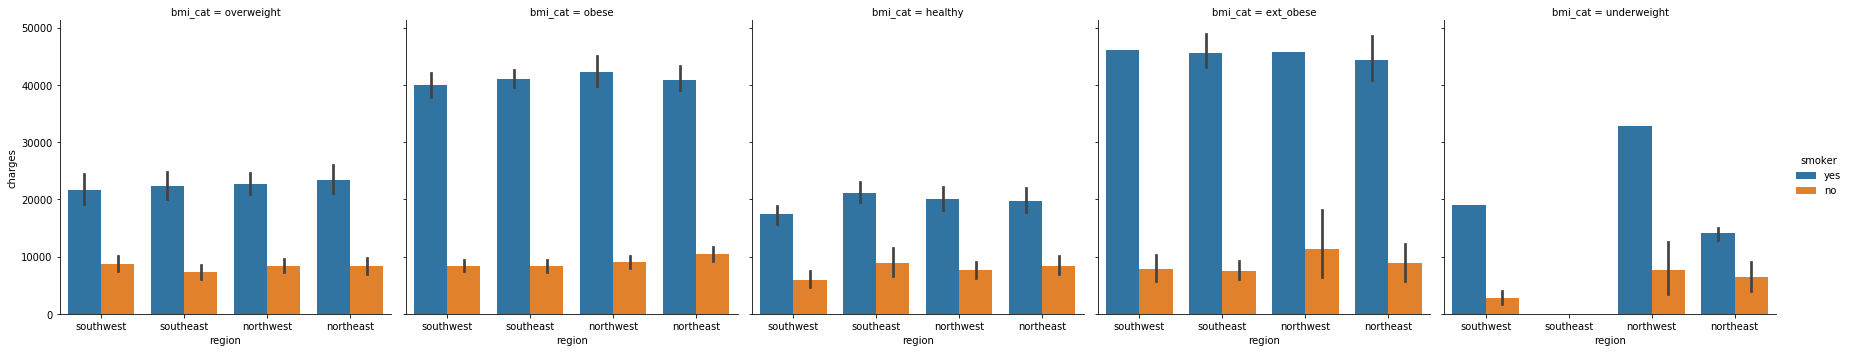

In [63]:
sns.catplot(x='region',y='charges',col='bmi_cat',hue='smoker',data=data,kind='bar')

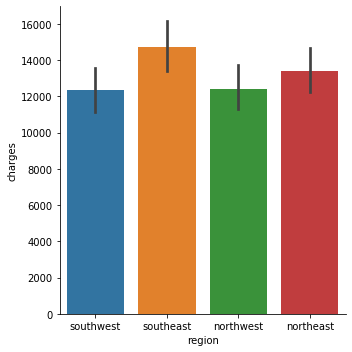

In [64]:
sns.catplot(x='region',y='charges',data=data,kind='bar')

We cannot find any trend in charges based on region, when we are consider all the factors. thus we will one hot code this feature.

In [65]:
data1=data.copy()

# FEATURE ENGINEERING

In [66]:
data1.head()

,age,sex,bmi,children,smoker,region,charges,age_cat,bmi_cat,child_cat
0,19,female,27.900,0,yes,southwest,16884.92400,Young,overweight,less
1,18,male,33.770,1,no,southeast,1725.55230,Young,obese,less
2,28,male,33.000,3+,no,southeast,4449.46200,Adult,obese,more
3,33,male,22.705,0,no,northwest,21984.47061,Adult,healthy,less
4,32,male,28.880,0,no,northwest,3866.85520,Adult,overweight,less


In [67]:
data1=data1.drop(['age','bmi','children'],axis=1)


In [68]:
data1['age_cat'].unique()

array(['Young', 'Adult', 'Senior Adult', 'Elder'], dtype=object)

In [69]:
data1['bmi_cat'].unique()

array(['overweight', 'obese', 'healthy', 'ext_obese', 'underweight'],
      dtype=object)

In [70]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
sex          1338 non-null object
smoker       1338 non-null object
region       1338 non-null object
charges      1338 non-null float64
age_cat      1338 non-null object
bmi_cat      1338 non-null object
child_cat    1338 non-null object
dtypes: float64(1), object(6)
memory usage: 73.3+ KB


In [71]:
data1['age_cat']=data1['age_cat'].map({'Young':0, 'Adult':1, 'Senior Adult':2, 'Elder':3})
data1['bmi_cat']=data1['bmi_cat'].map({'underweight':0, 'healthy':1, 'overweight':2, 'obese':3,'ext_obese':4})
data1['child_cat']=data1['child_cat'].map({'less':0, 'more':1})


In [72]:
#data_hot=data1[['sex','smoker','region','age_cat','bmi_cat','child_cat']]

In [73]:
#data_hot1 = pd.get_dummies(data_hot)

In [74]:
#data_final=pd.concat([data_hot1,data1['charges']],axis=1)

In [75]:
data1.head()

,sex,smoker,region,charges,age_cat,bmi_cat,child_cat
0,female,yes,southwest,16884.92400,0,2,0
1,male,no,southeast,1725.55230,0,3,0
2,male,no,southeast,4449.46200,1,3,1
3,male,no,northwest,21984.47061,1,1,0
4,male,no,northwest,3866.85520,1,2,0


In [76]:
data1['smoker']=data1['smoker'].map({'no':0, 'yes':1})

In [77]:
data1.head()

,sex,smoker,region,charges,age_cat,bmi_cat,child_cat
0,female,1,southwest,16884.92400,0,2,0
1,male,0,southeast,1725.55230,0,3,0
2,male,0,southeast,4449.46200,1,3,1
3,male,0,northwest,21984.47061,1,1,0
4,male,0,northwest,3866.85520,1,2,0


In [78]:
data_hot = pd.get_dummies(data1['region'])
data_hot1 = pd.get_dummies(data1['sex'])

In [79]:
data1

,sex,smoker,region,charges,age_cat,bmi_cat,child_cat
0,female,1,southwest,16884.92400,0,2,0
1,male,0,southeast,1725.55230,0,3,0
2,male,0,southeast,4449.46200,1,3,1
3,male,0,northwest,21984.47061,1,1,0
4,male,0,northwest,3866.85520,1,2,0
...,...,...,...,...,...,...,...
1333,male,0,northwest,10600.54830,2,3,1
1334,female,0,northeast,2205.98080,0,3,0
1335,female,0,southeast,1629.83350,0,3,0
1336,female,0,southwest,2007.94500,0,2,0


In [80]:
data1=data1.drop(['region','sex'],axis=1)

In [81]:
data_final=pd.concat([data1,data_hot,data_hot1],axis=1)

In [82]:
data_final.head()

,smoker,charges,age_cat,bmi_cat,child_cat,northeast,northwest,southeast,southwest,female,male
0,1,16884.92400,0,2,0,0,0,0,1,1,0
1,0,1725.55230,0,3,0,0,0,1,0,0,1
2,0,4449.46200,1,3,1,0,0,1,0,0,1
3,0,21984.47061,1,1,0,0,1,0,0,0,1
4,0,3866.85520,1,2,0,0,1,0,0,0,1


Now the final part, we will work on charges. Let check the skewness.

# Skewness of dependent variable


 mu = 13270.42 and sigma = 12105.48



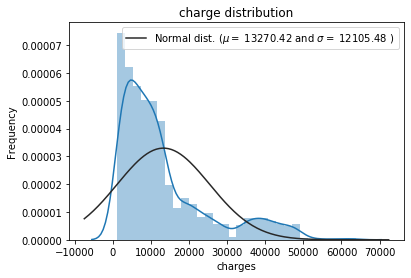

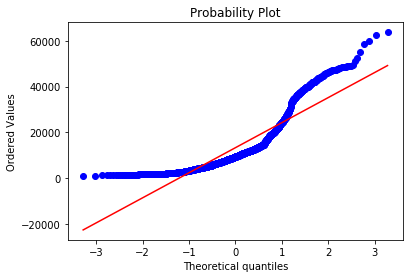

In [83]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

sns.distplot(data['charges'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_final['charges'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('charge distribution')

fig = plt.figure()
res = stats.probplot(data['charges'], plot=plt)
plt.show()

In [84]:
data_final.head()

,smoker,charges,age_cat,bmi_cat,child_cat,northeast,northwest,southeast,southwest,female,male
0,1,16884.92400,0,2,0,0,0,0,1,1,0
1,0,1725.55230,0,3,0,0,0,1,0,0,1
2,0,4449.46200,1,3,1,0,0,1,0,0,1
3,0,21984.47061,1,1,0,0,1,0,0,0,1
4,0,3866.85520,1,2,0,0,1,0,0,0,1


In [85]:
data_final.shape

(1338, 11)

In [86]:
#data_final=data_final.drop(['sex_male','smoker_no','region_southwest','age_cat_Young','bmi_cat_healthy','child_cat_more'],axis=1)

# Modelling

In [90]:
Data_out=data_final['charges']
input_data=data_final.drop(['charges'],axis=1)

In [91]:
from sklearn.preprocessing import PolynomialFeatures
quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(input_data)


In [92]:
R2_Scores = []
models1 = ['Linear Regression' , 'GradientBoosting Regression' ,'DecisionTreeRegressor','SVR','RandomForestRegressor','KNeighbours Regression']

In [93]:
#data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(input_data,Data_out,test_size=0.10)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,test_size=0.10)

In [94]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
#print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 1204
Number of data points in test data: 134


In [95]:
data_final.shape

(1338, 11)

# Standarization


In [96]:
# X_train.describe()


y_train= y_train.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)
#y_cv= y_cv.values.reshape(-1,1)

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
y_train = sc_X.fit_transform(y_train)
y_test = sc_y.fit_transform(y_test)
#X_cv = sc_X.fit_transform(X_cv)
#y_cv = sc_y.fit_transform(y_cv)

# Linear regression


In [97]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

lm.fit(X_train,y_train)
print(lm)

# print the intercept
print(lm.intercept_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[-4.92743489e-17]


In [98]:
print(lm.coef_)

[[ 0.78752885  0.28113039  0.16412374  0.05360447  0.01582247  0.00209888
  -0.00471958 -0.01301259  0.00511414 -0.00511414]]


In [99]:
lm_pred = lm.predict(X_test)
lm_pred= lm_pred.reshape(-1,1)
print("accuracy: "+ str(lm.score(X_test,y_test)*100) + "%")

accuracy: 85.63434027512113%


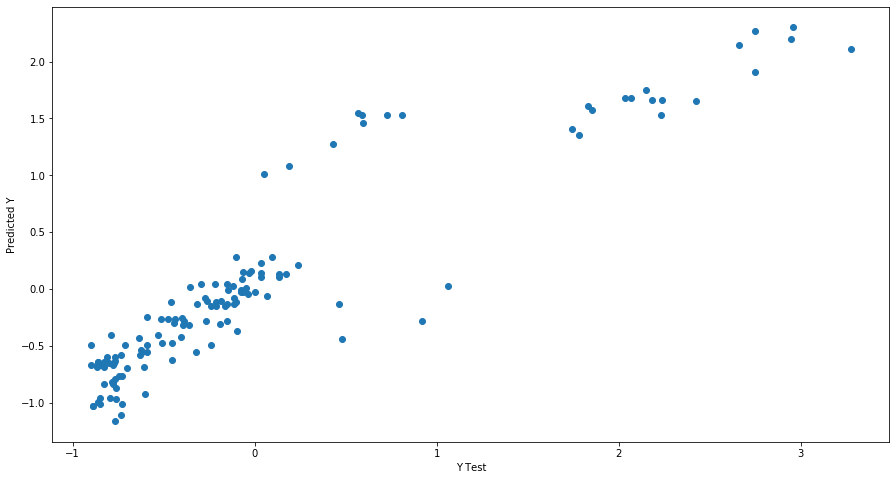

In [100]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,lm_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

In [101]:
from sklearn import metrics

In [102]:
r2=r2_score(y_test, lm_pred)
print('MAE:', metrics.mean_absolute_error(y_test, lm_pred))
print('MSE:', metrics.mean_squared_error(y_test, lm_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lm_pred)))
print('r2 score:',r2)
R2_Scores.append(r2)

MAE: 0.2618423016326132
MSE: 0.14365659724878868
RMSE: 0.3790205762868141
r2 score: 0.8563434027512113


# Gradient Boosting


In [103]:
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score

In [104]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [105]:
clf_pred=clf.predict(X_test)
clf_pred= clf_pred.reshape(-1,1)

In [106]:
r2=r2_score(y_test, clf_pred)
print('MAE:', metrics.mean_absolute_error(y_test, clf_pred))
print('MSE:', metrics.mean_squared_error(y_test, clf_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, clf_pred)))
print('r2 score:',r2)
R2_Scores.append(r2)

MAE: 0.12899938193480306
MSE: 0.06616504754379349
RMSE: 0.25722567434801974
r2 score: 0.9338349524562065


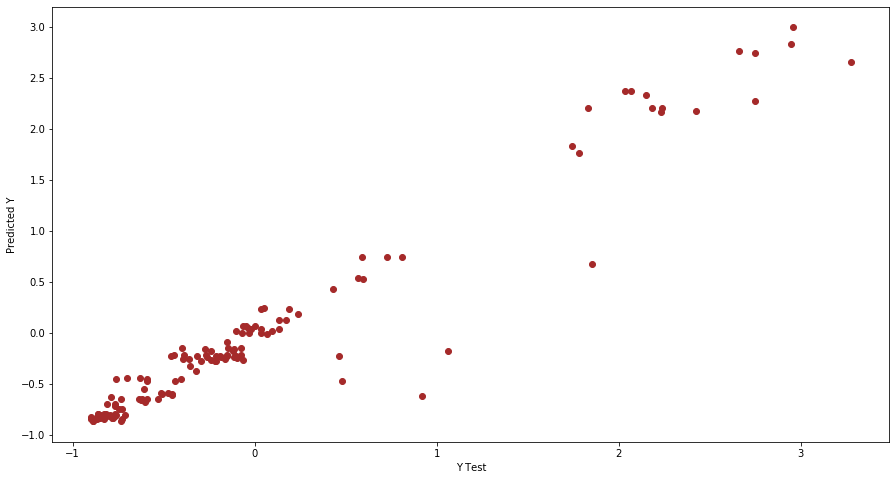

In [107]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,clf_pred, c= 'brown')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

# DecisionTreeRegressor


In [108]:
from sklearn.tree import DecisionTreeRegressor
dtreg = DecisionTreeRegressor(random_state = 100)
dtreg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=100, splitter='best')

In [109]:
dtr_pred = dtreg.predict(X_test)
dtr_pred= dtr_pred.reshape(-1,1)

In [110]:
r2=r2_score(y_test, dtr_pred)
print('MAE:', metrics.mean_absolute_error(y_test, dtr_pred))
print('MSE:', metrics.mean_squared_error(y_test, dtr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)))
print('r2 score:',r2)

R2_Scores.append(r2)

MAE: 0.21119295296331086
MSE: 0.13698244644255386
RMSE: 0.37011139734214327
r2 score: 0.8630175535574461


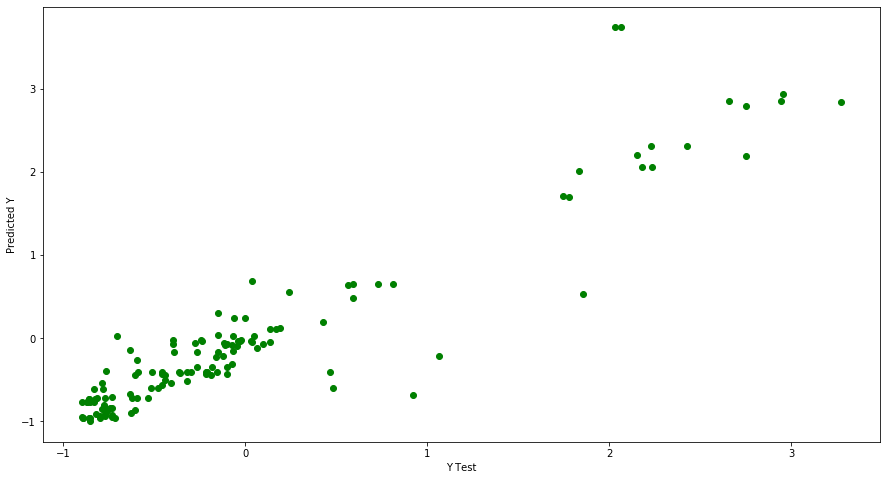

In [111]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,dtr_pred,c='green')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

# SVR

In [112]:
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf')
svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [113]:
svr_pred = svr.predict(X_test)
svr_pred= svr_pred.reshape(-1,1)

In [114]:
r2=r2_score(y_test, svr_pred)
print('MAE:', metrics.mean_absolute_error(y_test, svr_pred))
print('MSE:', metrics.mean_squared_error(y_test, svr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))
print('r2 score:',r2)

R2_Scores.append(r2)

MAE: 0.14170670424112838
MSE: 0.07491775399867835
RMSE: 0.2737110775958444
r2 score: 0.9250822460013216


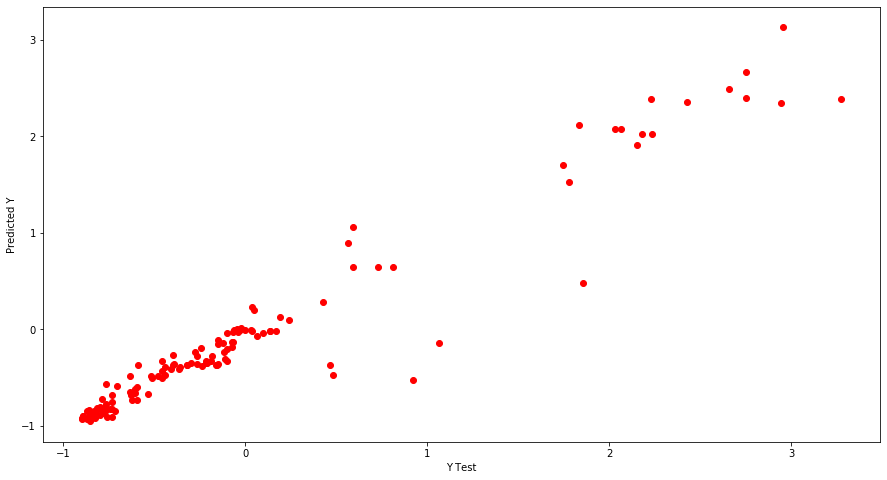

In [115]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,svr_pred, c='red')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

# RandomForestRegressor


In [116]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 1500, random_state = 0)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [117]:
rfr_pred= rfr.predict(X_test)
rfr_pred = rfr_pred.reshape(-1,1)

In [118]:
r2=r2_score(y_test, rfr_pred)
print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred))
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))
print('r2 score:',r2)

R2_Scores.append(r2)

MAE: 0.19637297724557973
MSE: 0.10700511726228204
RMSE: 0.3271163665460382
r2 score: 0.892994882737718


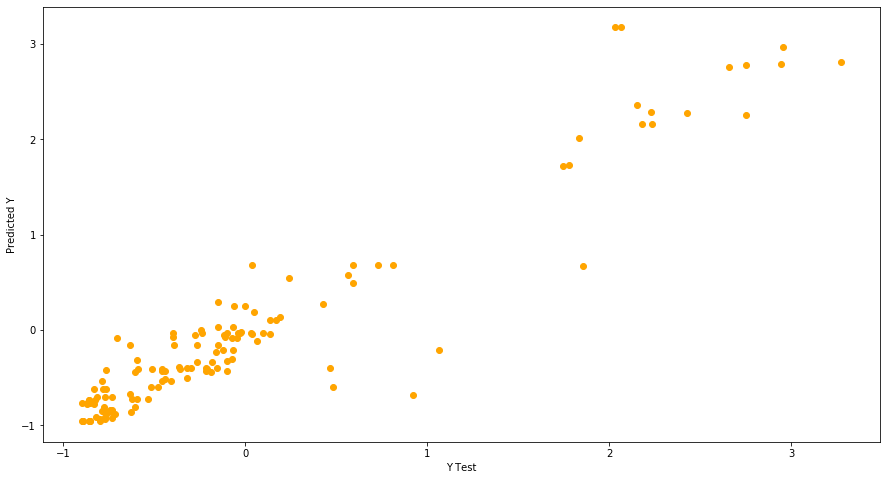

In [119]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,rfr_pred, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

# KNN

In [120]:
from sklearn.neighbors import KNeighborsRegressor
clf_knn = KNeighborsRegressor()
clf_knn.fit(X_train , y_train)
accuracies = cross_val_score(estimator = clf_knn, X = X_train, y = y_train, cv = 5,verbose = 1)
y_pred = clf_knn.predict(X_test)
print('')
print('###### KNeighbours Regression ######')
print('Score : %.4f' % clf_knn.score(X_test, y_test))
print(accuracies)

mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)


###### KNeighbours Regression ######
Score : 0.8677
[0.75579907 0.79044797 0.80472716 0.73113796 0.71715016]

MSE    : 0.13 
MAE    : 0.24 
RMSE   : 0.36 
R2     : 0.87 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [121]:
from sklearn.model_selection import GridSearchCV
n_neighbors=[]
for i in range (0,50,5):
    if(i!=0):
        n_neighbors.append(i)
params_dict={'n_neighbors':n_neighbors,'n_jobs':[-1]}
clf_knn=GridSearchCV(estimator=KNeighborsRegressor(),param_grid=params_dict,scoring='r2')
clf_knn.fit(X_train,y_train)
print('Score : %.4f' % clf_knn.score(X_test, y_test))
pred=clf_knn.predict(X_test)
r2 = r2_score(y_test, pred)
print('R2     : %0.2f ' % r2)
R2_Scores.append(r2)

Score : 0.8677
R2     : 0.87 


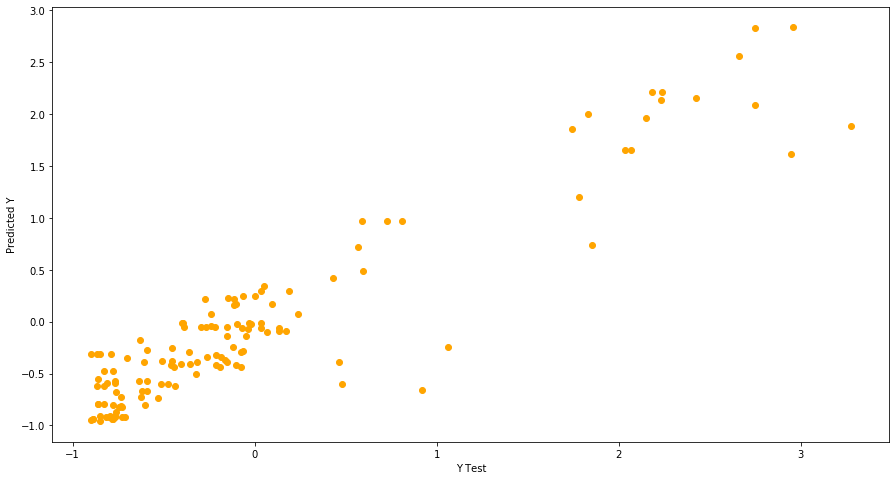

In [122]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,pred, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

In [123]:
compare = pd.DataFrame({'Algorithms' : models1 , 'R2-Scores' : R2_Scores})
compare.sort_values(by='R2-Scores' ,ascending=False)
compare

,Algorithms,R2-Scores
0,Linear Regression,0.856343
1,GradientBoosting Regression,0.933835
2,DecisionTreeRegressor,0.863018
3,SVR,0.925082
4,RandomForestRegressor,0.892995
5,KNeighbours Regression,0.867712
